# Predict Script

Scaling:
- max and mival are saved in model_params['scaling_dict'] 
- this dict is used in encode_data and predict funcs

In [1]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import numpy as np
import scipy, pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, os, json
from models import BiRNN_new, mlp, logreg
from data_util import get_data_set, one_hot_dataset, scale, unscale, int_dataset
from palettes import godsnot_64, zeileis_26
from bidirectional_lstm import predict
from data_util import Delta_t95, RMSE, Delta_tr95
from predict_util import get_color, plot_att
sns.set(rc={"axes.facecolor":"#e6e6e6",
            "axes.grid":True,
               })

model_dir = './out/Tests_200206_ward_min2_PTtest_2/'
file_to_predict = 'data_final/Tests/4/2_test.pkl'
datasetname='4_batch'

with open(model_dir+'model_params.json') as f:
    model_params = json.load(f)
print(model_params)
if file_to_predict != None:
    model_params['test_file'] = file_to_predict


model = BiRNN_new
print('Model: ', model)
figure_dir = model_params['model_dir'] + '/figures/'
lab_name = model_params['lab_name']
timesteps = model_params['timesteps']

with open('data_final/enc.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

c_dict = {}
for c,i in enumerate(label_encoder.classes_):
    c_dict[i]=godsnot_64[c]

/media/niklas/Data_3/MannProteomics_jean/MannProteomics/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/niklas/Data_3/MannProteomics_jean/MannProteomics/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/niklas/Data_3/MannProteomics_jean/MannProteomics/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

{'lab_name': 'label', 'fname': 'cache/one_dat_cache_full_label.npy', 'num_input': 32, 'timesteps': 66, 'num_hidden': 128, 'num_layers': 2, 'num_classes': 1, 'dropout_keep_prob': 0.9, 'use_uncertainty': False, 'use_attention': True, 'simple': False, 'num_tasks': -1, 'batch_size': 64, 'model_dir': 'out/Tests_200206_ward_min2_PTtest_2/', 'model_dir_pretrain': None, 'lr_base': 0.001, 'training_steps': 55000, 'reduce_lr_step': 50000, 'train_file': 'data_final/Tests/200206_ward_min2_PTtest/2_train.pkl', 'test_file': 'data_final/Tests/200206_ward_min2_PTtest/2_test.pkl', 'reduce_train': 0.5, 'scaling_dict': {'0': [275.41885375976557, 1118.7861328125]}}
Model:  <function BiRNN_new at 0x7fbf53ac8f28>


/media/niklas/Data_3/MannProteomics_jean/MannProteomics/env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
model_params


{'lab_name': 'label',
 'fname': 'cache/one_dat_cache_full_label.npy',
 'num_input': 32,
 'timesteps': 66,
 'num_hidden': 128,
 'num_layers': 2,
 'num_classes': 1,
 'dropout_keep_prob': 0.9,
 'use_uncertainty': False,
 'use_attention': True,
 'simple': False,
 'num_tasks': -1,
 'batch_size': 64,
 'model_dir': 'out/Tests_200206_ward_min2_PTtest_2/',
 'model_dir_pretrain': None,
 'lr_base': 0.001,
 'training_steps': 55000,
 'reduce_lr_step': 50000,
 'train_file': 'data_final/Tests/200206_ward_min2_PTtest/2_train.pkl',
 'test_file': 'data_final/Tests/4/2_test.pkl',
 'reduce_train': 0.5,
 'scaling_dict': {'0': [275.41885375976557, 1118.7861328125]}}

In [3]:
from predict_util import encode_data, get_tf_dataset

test_data = pd.read_pickle(model_params['test_file'])
print('Using %s' % (model_params['test_file']))
test_sequences = test_data['Modified_sequence'].values


data = test_data
org_columns = data.columns

replaced_charge = False
try:
    data[model_params['lab_name']]
except:
    data[model_params['lab_name']]=np.zeros(len(data))
    replaced_charge = True

one_dat, lab, meta_data, test_size = encode_data(data, model_params)

#build iterator on testdata
dataset_test = get_tf_dataset(one_dat, lab, meta_data, data, model_params) 
iter_test = dataset_test.make_initializable_iterator()
next_element_test = iter_test.get_next()



Using data_final/Tests/4/2_test.pkl
minmax 275.41885375976557 1118.7861328125
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#build graph
#tf.reset_default_graph()
if model_params['simple']:
    X = tf.placeholder("float", [None, model_params['num_input']])
else:
    X = tf.placeholder("float", [None, model_params['timesteps']])
if model_params['num_classes'] == 1:
    Y = tf.placeholder("float", [None, 1])
else:
    Y = tf.placeholder("int64", [None, 1])
if model_params['num_tasks'] != -1:
    T = tf.placeholder("int32", [None])
else:
    T=None
C = tf.placeholder("float", [None, meta_data.shape[1]])
L = tf.placeholder("int32", [None])
dropout = tf.placeholder("float", ())

if model_params['num_tasks'] == -1:
    prediction, logits, weights, biases, attention, cert = model(X, C, L, model_params['num_layers'], model_params['num_hidden'],  meta_data,
                                                                 model_params['num_classes'],
                                                                 model_params['timesteps'], keep_prob=dropout,
                                                                 uncertainty=model_params['use_uncertainty'], is_train=True)
else:
    prediction, logits, weights, biases, attention, cert = model(X, C, L, model_params['num_tasks'], model_params['num_layers'], model_params['num_hidden'], meta_data,
                                                                 model_params['num_classes'],
                                                                 model_params['timesteps'], keep_prob=dropout,
                                                                 uncertainty=model_params['use_uncertainty'], is_train=True)

if model_params['num_classes'] == 1:    
    if model_params['num_tasks'] == -1:
        loss_op = tf.losses.mean_squared_error(predictions=prediction, labels=Y)
    else: #multitask regression.

        pp = tf.reshape(tf.stack(prediction, axis=1), [-1, model_params['num_tasks']])
        ppp = tf.reshape(tf.reduce_sum(pp * tf.one_hot(T, model_params['num_tasks']), axis=1), [-1, 1])
        loss_op = tf.losses.mean_squared_error(predictions=ppp, labels=Y)
else:
    loss_op = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(Y,[-1]), logits=prediction)   
    loss_op = tf.reduce_mean(loss_op)
    prediction = tf.nn.softmax(prediction)
        
    
# Initialize the variables (i.e. assign their default value)
saver = loader = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES), max_to_keep=10)
#init model
init = [tf.global_variables_initializer(), iter_test.initializer]
# Start training
sess = tf.Session()


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Tensor("concat:0", shape=(?, 256), dtype=float32) Tensor("stack_bidirectional_rnn/cell_1/bidirectional_rnn/bw/bw/while/Exit_4:0", shape=(?, 128), dtype=float32) Tensor("stack_bidirectional_rnn/cell_1/bidirectional_rnn/fw/fw/while/Exit_4:0", shape=(?, 128), dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [5]:
#predictions
sess.run(init)
model_file = tf.train.latest_checkpoint(model_params['model_dir'])
if model_file:
    ind1 = model_file.index('model')
    resume_itr = int(model_file[ind1+5:])
    print("Restoring model weights from " + model_file)
    saver.restore(sess, model_file)
else:
    print('no model found!')

Restoring model weights from out/Tests_200206_ward_min2_PTtest_2/model55000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from out/Tests_200206_ward_min2_PTtest_2/model55000


In [6]:
n_preds = 1
for i in range(n_preds):
    label, preds, last, seq, charge, loss, att, unc, task  = predict(sess, X, Y, C, L, T, test_size, model_params, next_element_test, loss_op, prediction, logits, attention, meta_data, dropout, cert, dropout_rate = model_params['dropout_keep_prob'])
    #label, preds, last, seq, charge, loss, att, unc, task  = predict(sess, X, Y, C, L, T, test_size, model_params, next_element_test, loss_op, prediction, logits, attention, meta_data, dropout, cert, dropout_rate = 1.0)
    if model_params['num_classes'] != 1:
        preds = np.argmax(preds,axis=1).reshape(-1,1)
    data['label Prediction ' + str(i)] = preds[:,0]
    sess.run(iter_test.initializer)

In [7]:
#data['attention'] = att.tolist()
#data['last'] = last.tolist()
#data[lab_name+' Prediction']= np.mean(data[['label Prediction ' + str(i) for i in range(n_preds)]], axis=1)
#data.to_hdf(figure_dir+'data.h5', key='data')
#data.to_csv(figure_dir+'data.csv')


In [8]:
df = data
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
inline_rc = dict(mpl.rcParams)
sns.set(rc={"axes.facecolor":"#ffffff",
            "axes.grid":False,
})
sns.set_style('ticks')
sns.despine()

#df = pd.read_hdf(figure_dir+'data.h5')

if replaced_charge:
    data['Charge'] = data['Charge Prediction']
    
    

/media/niklas/Data_3/MannProteomics_jean/MannProteomics/env/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [9]:
print(data[['Modified_sequence',model_params['lab_name'],model_params['lab_name']+' Prediction 0']].head())

       Modified_sequence  label  label Prediction 0
0  RM(ox)IPANPRPGRMGSAFK      0          656.129333
1               LEQCMASK      0          513.634766
2          KEHRYLSSYVPFA      0          624.250610
3                MACGLVR      0          490.291412
4      EGM(ox)ALTLGLAATR      0          636.545898


In [10]:
set(data['Charge'].values)

{4}

In [11]:
if model_params['lab_name'] != 'Charge':
    data['label'] = data['CCS']

In [12]:
data.head()

,Unnamed: 0,Sequence,Modified_sequence,Charge,len,CCS,label,encseq,minval,maxval,test,task,lens,label Prediction 0
0,12692636,RMIPANPRPGRMGSAFK,RM(ox)IPANPRPGRMGSAFK,4,21,0,0,"[16, 12, 0, 25, 26, 1, 9, 14, 2, 13, 14, 16, 1...",275.418854,1118.786133,True,0,21,656.129333
1,12692637,LEQCMASK,LEQCMASK,4,8,0,0,"[11, 5, 15, 3, 12, 2, 17, 10]",275.418854,1118.786133,True,0,8,513.634766
2,12692638,KEHRYLSSYVPFA,KEHRYLSSYVPFA,4,13,0,0,"[10, 5, 8, 16, 21, 11, 17, 17, 21, 19, 14, 6, 2]",275.418854,1118.786133,True,0,13,624.250610
3,12692639,MACGLVR,MACGLVR,4,7,0,0,"[12, 2, 3, 7, 11, 19, 16]",275.418854,1118.786133,True,0,7,490.291412
4,12692640,EGMALTLGLAATR,EGM(ox)ALTLGLAATR,4,17,0,0,"[5, 7, 12, 0, 25, 26, 1, 2, 11, 18, 11, 7, 11,...",275.418854,1118.786133,True,0,17,636.545898


In [13]:
data[['Modified_sequence','Charge','label Prediction 0']].to_csv(figure_dir + 'prediction_'+model_params['lab_name']+'_'+datasetname+'.csv')
print('saved to', figure_dir + 'prediction_'+model_params['lab_name']+'_'+datasetname+'.csv')

saved to out/Tests_200206_ward_min2_PTtest_2//figures/prediction_label_4_batch.csv


# Plots

1.3397840023999024


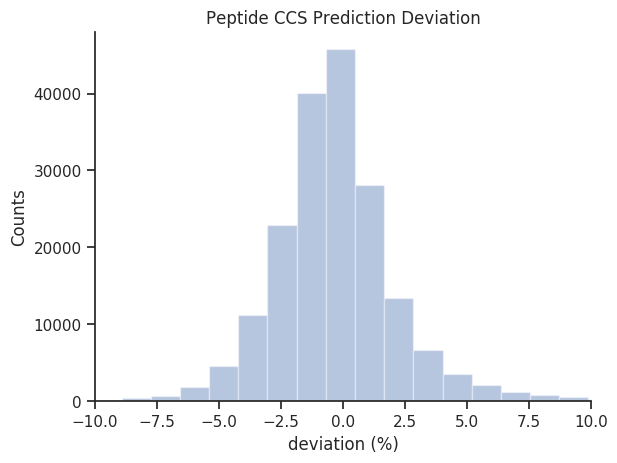

In [14]:
df['rel'] = (df[lab_name] / df[lab_name+' Prediction'] ) * 100 - 100
df['abs'] = np.abs(df[lab_name] - df[lab_name+' Prediction'])

rel = df['rel'].values
rel_abs = np.abs(df['rel'].values)
abs = df['abs'].values
print(np.median(rel_abs))
ax = sns.distplot(rel, norm_hist=False, kde = False, bins=50)    #, bins=200
ax.set(xlabel='deviation (%)', ylabel='Counts')
ax.set(xlim = [-10, 10])

sns.despine()
plt.title('Peptide CCS Prediction Deviation')
plt.savefig(figure_dir + '/rel_error.svg', dpi=300)
plt.show()

ppred = df[lab_name+' Prediction']
llabel = df[lab_name]

Pearson 0.9918322471613341


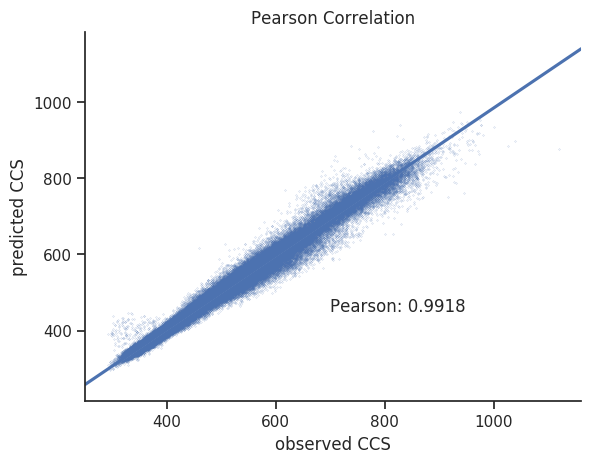

In [15]:
ax = sns.regplot(x=df[lab_name], y=df[lab_name+' Prediction'],scatter_kws={'s':0.02})#, scatter_kws={'color' : ccs}
pearson = scipy.stats.pearsonr(df[lab_name+' Prediction'], df[lab_name])
print('Pearson', pearson[0])
ax.set(xlabel='observed CCS', ylabel='predicted CCS')

plt.text(700,450,'Pearson: {:.4f}'.format(pearson[0]))

plt.title('Pearson Correlation')
sns.despine()
plt.savefig(figure_dir + '/pearson.png', dpi=300)

plt.show()


In [18]:
df['maxval']

1         1118.786133
22        1118.786133
28        1118.786133
60        1118.786133
118       1118.786133
             ...     
718911    1118.786133
718912    1118.786133
718913    1118.786133
718915    1118.786133
718916    1118.786133
Name: maxval, Length: 185248, dtype: float64